In [2]:
# 1.导入必要的库
# 查看GPU信息：https://discuss.pytorch.org/t/i-have-3-gpu-why-torch-cuda-device-count-only-return-1/7245
# 解决CUDA版本不能绘制图像问题  https://pretagteam.com/question/dead-kernel-after-running-torchvisionutilsmakegridimages
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch
import sys
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as trans
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter   
from subprocess import call
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 输出Pytorch以及CUDA信息
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__pyTorchVision VERSION:', torchvision.__version__)
print('__CUDA VERSION')
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.10.0+cu102
__pyTorchVision VERSION: 0.11.1+cu102
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [4]:

# 超参数
BATCH_SIZE = 1000 #训练时每次送入图片的数量
nepochs = 10 #训练次数
LR = 0.01 #学习率

# 定义损失函数为交叉熵损失 loss_func
loss_func = nn.CrossEntropyLoss()

# 可以在GPU或者CPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# 2.CIFAR10数据集的预处理
n_train_samples = 50000
n_test_samples = 10000
n_train_loss_samples = 1000 #得到训练误差用的
# 全局取消证书验证
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# 如果是多进程需要加一个main函数，否则会报错
if __name__ == '__main__':
    
    # 数据增强-->训练集
    train_set = dsets.CIFAR10(root='CIFAR10/',  # 数据集保存路径
                              train=True,
                              download=False,   # 如果未下载，改为True；如果已经下载好，改为False
                              transform=trans.Compose([
                                 trans.RandomHorizontalFlip(),
                                 trans.RandomCrop(32, padding=4),
                                 trans.ToTensor(),
                                 trans.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ]))
    train_subSet = torch.utils.data.Subset(train_set, range(0,n_train_samples))#取子集
    train_dl = DataLoader(train_subSet,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6,
                          )        # 多进程
    #训练误差用的
    train_loss_subSet = torch.utils.data.Subset(train_set, range(0,n_train_loss_samples))
    train_loss_dl = DataLoader(train_loss_subSet,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6,
                          ) 

    # 测试集                
    train_subSet = torch.utils.data.Subset(train_set, range(0,n_train_samples))
    test_set = dsets.CIFAR10(root='CIFAR10/',   # 数据集保存路径
                             train=False,
                             download=False,    # 如果未下载，改为True；如果已经下载好，改为False
                             transform=trans.Compose([
                                trans.ToTensor(),
                                trans.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))
    test_subSet = torch.utils.data.Subset(test_set,range(0,n_test_samples))
    test_dl = DataLoader(test_subSet,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=6)         # 多进程
    CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

训练集大小:50000
测试集大小:10000
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
一张图片的数组size:(32, 32, 3)


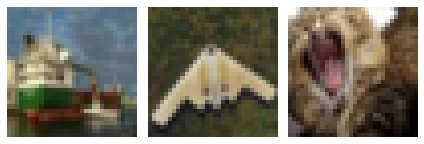

In [14]:
#输出CIFAR-10数据集训练集、测试集大小
print("训练集大小:{}".format(train_set.data.shape[0]))
print("测试集大小:{}".format(test_set.data.shape[0]))
#所有类别名称及与label对应情况
print(dict(zip(CIFAR_LABELS,(0,1,2,3,4,5,6,7,8,9))))
# 显示3张测试集图像
def show(img):
    # unnormalize（反归一化），因为前面数据进行load时使用的
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # 是先减0.5再除以0.5，现在反过来
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()# 避免gpu形式的数据
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',cmap="gray") #从数据库拿出来的图片是(3,x,x)形式，所以需要转化一下
print("一张图片的数组size:{}".format(train_set.data[50].shape))
for i in range(1,4):
    plt.subplot(1,3,i)
    plt.axis("off")
    test_img, _ = test_set[50+i]
    show(test_img)
plt.tight_layout()

In [27]:
# 3.定义训练的辅助函数，其中包括误差 error 与正确率 accuracy
def eval(model, loss_func, dataloader):

    model.eval()
    loss, accuracy = 0, 0
    # torch.no_grad显示地告诉pytorch，前向传播的时候不需要存储计算图
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            error = loss_func(logits, batch_y)
            loss += error.item()

            probs, pred_y = logits.data.max(dim=1)
            accuracy += (pred_y==batch_y.data).float().sum()/batch_y.size(0)

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy


def train_epoch(model, loss_func, optimizer, dataloader):

    model.train()
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        error = loss_func(logits, batch_y)
        error.backward()
        optimizer.step()

In [28]:
# 搭建CNNNet
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
        # Convolutional layers
        nn.Conv2d(3, 16, 3, padding=1),
        # nn.ReLU(True),#激活函数
        # nn.Tanh(),
        # Pooling layers
        nn.MaxPool2d(2,2),
        nn.Conv2d(16, 32, 3, padding=1),
        # nn.ReLU(True),
        # nn.Tanh(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32, 64, 3, padding=1),
        # nn.ReLU(True),
        # nn.Tanh(),
        nn.MaxPool2d(2,2)
        )
        
        self.classifier = nn.Sequential(
        # Dropout layer
        nn.Dropout(0.25),
        # FC layers
        # Linear layer (64x4x4 -> 500)
        nn.Linear(64 * 4 * 4, 500),
        # nn.ReLU(True),
        # nn.Tanh(),
        nn.Dropout(0.25),
        # Linear Layer (500 -> 10)
        nn.Linear(500, 10),
        )
    def forward(self, x):
        x=self.features(x)
        # Flatten the image
        x = x.view(-1, 64*4*4)
        x = self.classifier(x)
        return x


In [29]:
isTrained = None
# 尝试加载已有模型
try:
    cnnNet = torch.load('./model/cnnNet.pkl') #需要改名
    # cnnNet.to(device)
    print("成功加载已有模型")
    isTrained = True
except:
    print("未检测到已有模型，新建训练模型")
    isTrained = False
    cnnNet = CNNNet().to(device)
    # 使用Adam进行优化处理
    optimizer = torch.optim.Adam(cnnNet.parameters(), lr=LR)
    # scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=0.1) #可以设置学习率自动调整
    learn_history = []
    time_stamp = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())#时间戳
    # dummy_input = torch.rand(30, 3, 32, 32)  # 假设输入30张3*32*32的图片
    # with SummaryWriter(log_dir="log/Graph/"+time_stamp,comment='cnnNet') as w:
    #     w.add_graph(cnnNet.cpu(), (dummy_input,))#tensorboard模型可视化
# 可以通过打印CNNNet观察具体的网络结构
print(cnnNet) 



未检测到已有模型，新建训练模型
CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1024, out_features=500, bias=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [30]:
isTrained = True
if not isTrained:
    
    print('开始训练cnnNet……')
    # tensorboard教程：https://blog.csdn.net/Yonggie/article/details/104326432?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_title~default-0.no_search_link&spm=1001.2101.3001.4242.1
    comment=f'bath_size={BATCH_SIZE} lr={LR}'
    writer=SummaryWriter(log_dir="log/"+time_stamp+"_bs%d_lr%.4f"%(BATCH_SIZE,LR),comment=comment)#防止多个event紊乱需要每次运行时创建新文件夹


    
    for epoch in range(nepochs):
        # 训练开始时间
        since = time.time()
        train_epoch(cnnNet, loss_func, optimizer, train_dl)
        
        # 每训练n轮输出一次结果
        if (epoch)%1 == 0:
            tr_loss, tr_acc = eval(cnnNet, loss_func, train_loss_dl)
            # te_loss, te_acc = eval(cnnNet, loss_func, test_dl)
            learn_history.append((tr_loss, tr_acc))
            writer.add_scalar('tr_loss', tr_loss, epoch)
            writer.add_scalar('tr_acc', tr_acc, epoch)
            # 完成一批次训练的结束时间
            now = time.time()
            # print('[%3d/%d, %.0f seconds]|\t 训练误差: %.1e, 训练正确率: %.2f\t |\t 测试误差: %.1e, 测试正确率: %.2f'%(
            #     epoch+1, nepochs, now-since, tr_loss, tr_acc, te_loss, te_acc))
            print('[%3d/%d, %.0f seconds]|\t 训练误差: %.1e, 训练正确率: %.2f\t'%(
                epoch+1, nepochs, now-since, tr_loss, tr_acc))
            
    isTrained = True
    writer.close()
    # 保存训练模型
    torch.save(cnnNet, './model/{}_bs{}_lr{}.pkl'.format(time_stamp,BATCH_SIZE,LR))#如果没有model文件夹需要手动创建一个

真实标签: horse 7 预测标签: ship 2 预测概率: 0.1008305773139
真实标签: horse 7 预测标签: bird 6 预测概率: 0.10915092378854752
真实标签: automobile 1 预测标签: bird 2 预测概率: 0.0964759811758995
真实标签: bird 2 预测标签: frog 7 预测概率: 0.10461223125457764
真实标签: horse 7 预测标签: bird 6 预测概率: 0.10396437346935272
真实标签: truck 9 预测标签: horse 7 预测概率: 0.10066509246826172
真实标签: truck 9 预测标签: automobile 7 预测概率: 0.0978071540594101
真实标签: deer 4 预测标签: ship 2 预测概率: 0.09324562549591064
真实标签: deer 4 预测标签: bird 2 预测概率: 0.09378886222839355
真实标签: automobile 1 预测标签: bird 2 预测概率: 0.1001189649105072


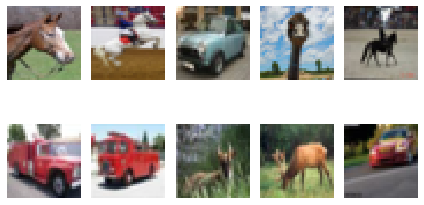

In [31]:
torch.cuda.empty_cache()
#预测
def tell(img, label, model):
    print("真实标签:", CIFAR_LABELS[label], label,end=' ')
    print("预测标签:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item(),end=" ")
    # print("所有标签预测概率:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("预测概率:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
for i in range(10):
    test_img, test_label = test_set[620+i]
    test_img = test_img.to(device)
    plt.subplot(2,5,i+1)
    plt.axis("off")
    show(test_img)
    tell(test_img, test_label, cnnNet)
plt.tight_layout()

# 实现kNN分类
https://blog.csdn.net/qq_40064490/article/details/118905891?spm=1001.2101.3001.6650.7&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EOPENSEARCH%7Edefault-7.no_search_link&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EOPENSEARCH%7Edefault-7.no_search_link

In [34]:
import pickle
from tqdm import tqdm

In [35]:
class KNNClassifier:
    def __init__(self, k):
        self.path = './CIFAR10/cifar-10-batches-py/'
        self.trainX = []
        self.trainY = []
        self.testX = None
        self.testY = None
        self.topk = k

    def train(self):
        self.load_cifar()

    def test(self):
        res = []
        for i, test_pic in enumerate(self.testX[:100]):
            score = {}
            print(i,end=":   ")
            for j, train_pic in tqdm(enumerate(self.trainX)):
                score[j] = (np.sum(np.abs(test_pic - train_pic)))

            # top-k
            score = sorted(score.items(), key=lambda x: x[1]) # min->max
            top_k = {}
            for m in range(k):
                if self.trainY[score[m][0]] not in top_k.keys():
                    top_k[self.trainY[score[m][0]]] = 1
                else:
                    top_k[self.trainY[score[m][0]]] += 1
            best_idx = np.argmax(list(top_k.values()))
            res.append(list(top_k.keys())[best_idx])
        correct = np.count_nonzero(res == self.testY[:100])
        acc = correct/100
        print("acc: {}".format(acc))
        return acc

    def load_cifar(self):
        for i in range(5):
            with open(self.path + 'data_batch_' + str(i + 1), 'rb') as f:
                a = pickle.load(f, encoding='iso-8859-1')  # labels\data\filenames
                self.trainX.append(a['data'])
                self.trainY.append(a['labels'])
        self.trainX = np.reshape(self.trainX, (50000, 32 * 32 * 3))
        self.trainY = np.reshape(self.trainY, (50000,))
        with open(self.path + 'test_batch', 'rb') as f:
            a = pickle.load(f, encoding='iso-8859-1')
            self.testX = np.reshape(a['data'], (len(a['data']), 32 * 32 * 3))
            self.testY = np.reshape(a['labels'], (len(a['data']),))

In [ ]:
if __name__ == '__main__':
    time_stamp = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())
    writer=SummaryWriter(log_dir="log/"+time_stamp+"KNN")
    for k in range(5,101,5):
        knn = KNNClassifier(k) # top-k
        knn.train()
        acc = knn.test()
        writer.add_scalar('Accuracy',acc, k) 
        
    writer.close()

In [25]:
acc